<h1> <center> <strong> Naive Bayes </strong> </center> </h1>

### Introduction

In this notebook, you will be implementing a Multi-Nomial Naive Bayes model.

Your task is to:
1. Implement the **Multinomial Naive Bayes** from scratch, adhering to the guidelines below regarding allowed libraries.
2. Apply the model using the `sklearn` library and compare the results with your own implementation.

<h3> <strong> 1) Library Imports </strong> </h3>

In [1]:
!pip install datasets
!pip install nltk

In [2]:
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.naive_bayes import MultinomialNB

nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/harisrana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h3> <strong> 2) Loading Dataset </strong> </h3>

In this assignment, you are provided with the following dataset:
- Tweet Evaluation Dataset (to be loaded from Hugging Face)

**Tweet Evaluation Dataset**: Instead of downloading the dataset manually, we will be using the [`datasets`](https://huggingface.co/docs/datasets) library from Hugging Face to automatically download and manage the Tweet Eval dataset. This library is part of the Hugging Face ecosystem, widely used for Natural Language Processing (NLP) tasks. The `datasets` library not only downloads the dataset but also offers a standardized interface for accessing and handling the data, making it compatible with other popular libraries like Pandas and PyTorch. Format each split of the dataset into a Pandas DataFrame. The columns should be `text` and `label`, where `text` is the sentence and `label` is the emotion label. The goal is to classify tweets into various emotional categories (e.g., joy, sadness, anger) by analyzing their content.

   You can explore the extensive list of datasets available on Hugging Face [here](https://huggingface.co/datasets).

In [3]:
tweet_data = load_dataset('tweet_eval', 'emotion', cache_dir="datasets")

train_data = pd.DataFrame(tweet_data['train'])
train_data.to_csv('emotion_train_data.csv', index=False)

validation_data = pd.DataFrame(tweet_data['validation'])
validation_data.to_csv('emotion_validation_data.csv', index=False)

test_data = pd.DataFrame(tweet_data['test'])
test_data.to_csv('emotion_test_data.csv', index=False)

In [5]:
print("Shape of tweets train data: ", train_data.shape)
print("Shape of tweets validation data: ", validation_data.shape)
print("Shape of tweets test data: ", test_data.shape)

Shape of tweets train data:  (3257, 2)
Shape of tweets validation data:  (374, 2)
Shape of tweets test data:  (1421, 2)


<h3> <strong> 3) Data Preprocessing </strong> </h3>

At this stage, you need to pre-process your data to ensure it's in a clean format for further analysis. The following steps should be performed:

- Remove any URL.
- Remove punctuation and non-alphanumeric characters.
- Convert all text to lowercase.
- Remove any extra whitespace.
- Eliminate common stopwords.

You can utilize the `re` library for cleaning text and the `nltk` library for removing stopwords.
Once the function is complete, apply it to the `text` column of your dataset to obtain the preprocessed text.

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_dataset(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_data['processed_text'] = train_data['text'].apply(preprocess_dataset)
validation_data['processed_text'] = validation_data['text'].apply(preprocess_dataset)
test_data['processed_text'] = test_data['text'].apply(preprocess_dataset)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harisrana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3> <strong> 4) Implementation of the Manual Naive Bayes Model </strong> </h3>

##### Vectorizing sentences with Bag of Words

Now that we have loaded in our data, we will need to vectorize our sentences - this is necessary to be able to numericalize our inputs before feeding them into our model. 

We will be using a Bag of Words approach to vectorize our sentences. This is a simple approach that counts the number of times each word appears in a sentence. 

The element at index $\text{i}$ of the vector will be the number of times the $\text{i}^{\text{th}}$ word in our vocabulary appears in the sentence. So, for example, if our vocabulary is `["the", "cat", "sat", "on", "mat"]`, and our sentence is `"the cat sat on the mat"`, then our vector will be `[2, 1, 1, 1, 1]`.

You will now create a `BagOfWords` class to vectorize our sentences. This will involve creating

1. A vocabulary from our corpus

2. A mapping from words to indices in our vocabulary

3. A function to vectorize a sentence in the fashion described above

In [7]:
class BagOfWords:
    def __init__(self):
        self.vocabulary = {}
    
    def fit(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.vocabulary:
                    self.vocabulary[word] = len(self.vocabulary)
    
    def vectorize(self, text):
        vector = np.zeros(len(self.vocabulary), dtype=int) 
        for word in text.split():
            if word in self.vocabulary:
                vector[self.vocabulary[word]] += 1
        return vector

For a sanity check, you can manually set the vocabulary of your `BagOfWords` object to the vocabulary of the example above, and check that the vectorization of the sentence is correct.

Once you have implemented the `BagOfWords` class, fit it to the training data, and vectorize the training, validation, and test data.

In [8]:
bow1 = BagOfWords()
bow1.vocabulary = {"the": 0, "cat": 1, "sat": 2, "on": 3, "mat": 4}
sentence = "the the cat sat on on the mat"
vector = bow1.vectorize(sentence)
print("Vectorized sentence:", vector)

Vectorized sentence: [3 1 1 2 1]


In [9]:
bow2 = BagOfWords()
bow2.fit(train_data['processed_text'])

train_data_vectors = np.array([bow2.vectorize(text) for text in train_data['processed_text']])
validation_data_vectors = np.array([bow2.vectorize(text) for text in validation_data['processed_text']])
test_data_vectors = np.array([bow2.vectorize(text) for text in test_data['processed_text']])



#### What is the Naive Bayes Model?

Now that we have vectorized our sentences, we can implement our Naive Bayes model. Recall that the Naive Bayes model is based off of the Bayes Theorem:

$$
P(y \mid x) = \frac{P(x \mid y)P(y)}{P(x)}
$$

What we really want is to find the class $c$ that maximizes $P(c \mid x)$, so we can use the following equation:

$$
\hat{c} = \underset{c}{\text{argmax}} \ P(c \mid x) = \underset{c}{\text{argmax}} \ P(x \mid c)P(c)
$$

We can then use the Naive Bayes assumption to simplify this:

$$
\hat{c} = \underset{c}{\text{argmax}} \ P(c \mid x) = \underset{c}{\text{argmax}} \ P(c) \prod_{i=1}^{n} P(x_i \mid c)
$$

Where $x_i$ is the $i^{\text{th}}$ word in our sentence.

All of these probabilities can be estimated from our training data. We can estimate $P(c)$ by counting the number of times each class appears in our training data, and dividing by the total number of training examples. We can estimate $P(x_i \mid c)$ by counting the number of times the $i^{\text{th}}$ word in our vocabulary appears in sentences of class $c$, and dividing by the total number of words in sentences of class $c$.

It would help to apply logarithms to the above equation so that we translate the product into a sum, and avoid underflow errors. This will give us the following equation:

$$
\hat{c} = \underset{c}{\text{argmax}} \ \log P(c) + \sum_{i=1}^{n} \log P(x_i \mid c)
$$

In [10]:
def train_MNB(X, y):
    classes, counts = np.unique(y, return_counts=True)
    num_classes = len(classes)
    priors = counts / len(y)
    num_features = X.shape[1]  
    likelihoods = np.zeros((num_classes, num_features))

    i = 0
    for class_label in classes:
        X_class = X[y == class_label] 
        word_count = X_class.sum() 
        likelihoods[i, :] = (X_class.sum(axis=0) + 1) / (word_count + num_features)
        i = i + 1 

    return priors, likelihoods, classes

def MNB_classifier(X, class_priors, likelihoods, classes):
    log_probabilities = np.zeros((X.shape[0], len(classes)))

    for i in range(len(classes)):
        class_label = classes[i]
        log_prior = np.log(class_priors[i])
        log_likelihood = np.log(likelihoods[i, :])
        log_probabilities[:, i] = log_prior + np.dot(X, log_likelihood.T)

    return classes[np.argmax(log_probabilities, axis=1)]

Now use your implementation to train a Naive Bayes model on the training data, and generate predictions for the Validation Set.

Report the Accuracy, Precision, Recall, and F1 score of your model on the validation data. Also display the Confusion Matrix. You are allowed to use `sklearn.metrics` for this.

<h3> <strong> 5) Testing the Model on Validation Data Set </strong> </h3>

In [11]:
class_priors, likelihoods, classes = train_MNB(train_data_vectors, train_data['label'].values)
validation_predictions = np.array(MNB_classifier(validation_data_vectors, class_priors, likelihoods, classes))
validation_actual = validation_data['label'].values

In [12]:
def make_heat_map(confusion_matrix, title):
  plt.figure(figsize=(10, 4))
  sns.heatmap(confusion_matrix, fmt="d", annot= True, cmap= "Blues", cbar= True)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()

def evaluate(y_actual, y_predicted, class_labels):
    accuracy = accuracy_score(y_actual, y_predicted)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    
    print("Classification Report:")
    print(classification_report(y_actual, y_predicted, target_names=list(map(str, class_labels))))
    
    cm = confusion_matrix(y_actual, y_predicted, labels=class_labels)
    make_heat_map(cm, "Confusion Matrix")

Accuracy: 64.97%

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.88      0.74       160
           1       0.75      0.45      0.56        97
           2       1.00      0.14      0.25        28
           3       0.61      0.61      0.61        89

    accuracy                           0.65       374
   macro avg       0.75      0.52      0.54       374
weighted avg       0.68      0.65      0.63       374



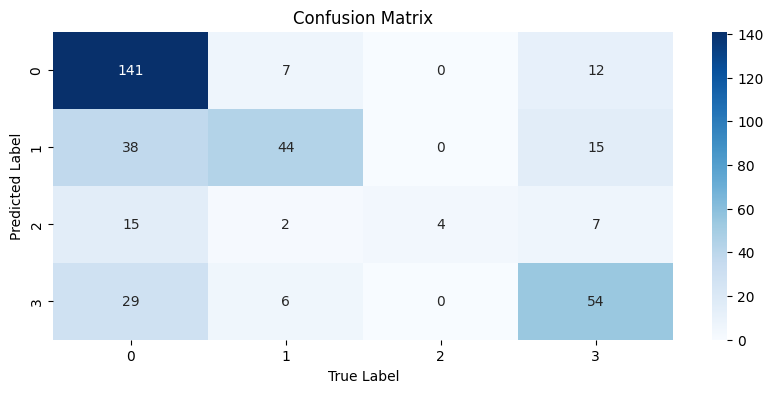

In [13]:
evaluate(validation_actual, validation_predictions, classes)

<h3> <strong> 6) Testing the Model on Test Data Set </strong> </h3>

In [14]:
class_priors, likelihoods, classes = train_MNB(train_data_vectors, train_data['label'].values)
test_predictions = np.array(MNB_classifier(test_data_vectors, class_priors, likelihoods, classes))
test_actual = test_data['label'].values

Accuracy: 65.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.90      0.73       558
           1       0.78      0.49      0.60       358
           2       0.67      0.11      0.19       123
           3       0.66      0.63      0.64       382

    accuracy                           0.65      1421
   macro avg       0.68      0.53      0.54      1421
weighted avg       0.67      0.65      0.63      1421



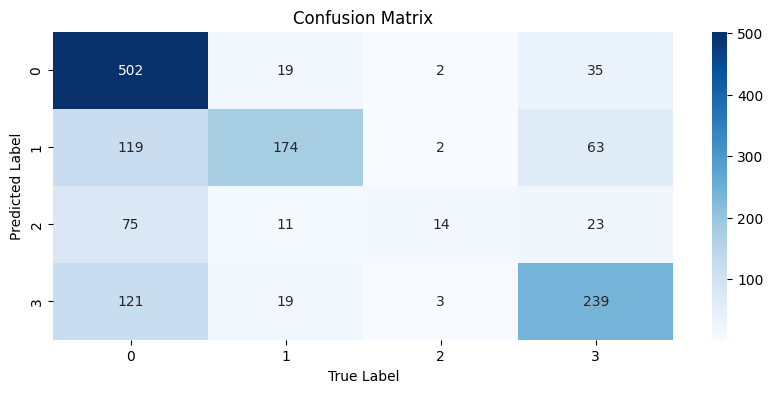

In [15]:
evaluate(test_actual, test_predictions, classes)

<h3> <strong> 7) Implementation of the Sklearn Naive Bayes Model </strong> </h3>

In [16]:
y_train = train_data['label'].values  
y_validation = validation_data['label'].values
y_test = test_data['label'].values

mnb = MultinomialNB()
mnb.fit(train_data_vectors, y_train)

y_validation_predicted_sklearn_MNB = mnb.predict(validation_data_vectors) 
y_test_predicted_sklearn_MNB = mnb.predict(test_data_vectors) 

sklearn_accuracy_validation = accuracy_score(y_validation, y_validation_predicted_sklearn_MNB) 
sklearn_accuracy_test = accuracy_score(y_test, y_test_predicted_sklearn_MNB)  
manual_accuracy_validation = accuracy_score(y_validation, validation_predictions)  
manual_accuracy_test = accuracy_score(y_test, test_predictions)  

print(f"Sklearn Multinomial Naive Bayes Accuracy for validation data set: {sklearn_accuracy_validation * 100:.2f}%")
print(f"Manual Multinomial Naive Bayes Accuracy for validation data set: {manual_accuracy_validation * 100:.2f}% \n")
print(f"Sklearn Multinomial Naive Bayes Accuracy for test data set: {sklearn_accuracy_test * 100:.2f}%")
print(f"Manual Multinomial Naive Bayes Accuracy for test data set: {manual_accuracy_test * 100:.2f}%")

Sklearn Multinomial Naive Bayes Accuracy for validation data set: 64.97%
Manual Multinomial Naive Bayes Accuracy for validation data set: 64.97% 

Sklearn Multinomial Naive Bayes Accuracy for test data set: 65.38%
Manual Multinomial Naive Bayes Accuracy for test data set: 65.38%
